In [1]:
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [5]:
def unzip_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to: {extract_to}")

In [6]:
unzip_folder("/content/archive.zip","/content/")

Extracted files to: /content/


In [7]:
import os
import shutil

# Paths to the main directories
normal_dir = '/content/Data/NORMAL'
hemorrhagic_dir = '/content/Data/Hemorrhagic'

# Move images from subfolders in NORMAL
for root, dirs, files in os.walk(normal_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Move file to the main NORMAL directory if it’s not already there
        # Check if the file exists in the destination before moving
        destination_path = os.path.join(normal_dir, file)
        if file_path != destination_path and not os.path.exists(destination_path):
            shutil.move(file_path, normal_dir)

# Move images from subfolders in Hemorrhagic
for root, dirs, files in os.walk(hemorrhagic_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Move file to the main Hemorrhagic directory if it’s not already there
        # Check if the file exists in the destination before moving
        destination_path = os.path.join(hemorrhagic_dir, file)
        if file_path != destination_path and not os.path.exists(destination_path):
            shutil.move(file_path, hemorrhagic_dir)

# Now you can remove empty subfolders if desired
for root, dirs, files in os.walk(normal_dir):
    for dir in dirs:
        shutil.rmtree(os.path.join(root, dir))

for root, dirs, files in os.walk(hemorrhagic_dir):
    for dir in dirs:
        shutil.rmtree(os.path.join(root, dir))

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

normal_images = len(os.listdir('/content/Data/NORMAL'))
hemorrhagic_images = len(os.listdir('/content/Data/Hemorrhagic'))

print(f"Normal images: {normal_images}, Hemorrhagic images: {hemorrhagic_images}")

# Create the ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale image pixel values to [0, 1]
    validation_split=0.3,       # Validation split
    width_shift_range=0.2,      # Shift images horizontally by 20%
    height_shift_range=0.2,     # Shift images vertically by 20%
    rotation_range=40,          # Rotate images randomly up to 40 degrees
    zoom_range=0.2,             # Zoom in/out on images by 20%
    shear_range=0.2,            # Shear transformation up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Create the training generator (70% of data)
train_generator = datagen.flow_from_directory(
    '/content/Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='training',      # Use the 'training' subset (70% of data)
    shuffle=True            # Shuffle training data
)

# Create the validation generator (30% of data)
validation_generator = datagen.flow_from_directory(
    '/content/Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='validation',    # Use the 'validation' subset (30% of data)
    shuffle=False           # Don't shuffle validation data
)


Normal images: 4105, Hemorrhagic images: 2689
Found 4757 images belonging to 2 classes.
Found 2037 images belonging to 2 classes.


Labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


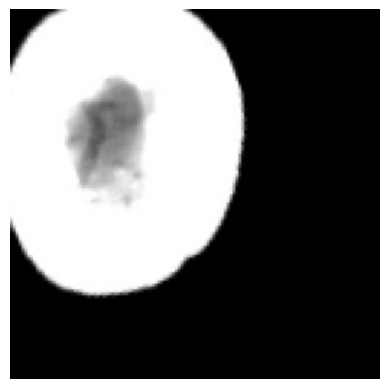

In [9]:
# Get one batch of images and labels from the training generator
images, labels = next(validation_generator)

# Get the first image from the batch
image = images[0]
print("Labels: ", labels)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

# Create the model
model = models.Sequential([

    # First Convolutional Layer with L2 Regularization
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                  kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Dropout after first conv layer
    layers.Dropout(0.3),  # Dropout with 30% probability

    # Second Convolutional Layer with L2 Regularization
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Dropout after second conv layer
    layers.Dropout(0.3),  # Dropout with 30% probability

    # Third Convolutional Layer with L2 Regularization
    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Dropout after third conv layer
    layers.Dropout(0.3),  # Dropout with 30% probability

    # Fourth Convolutional Layer with L2 Regularization
    layers.Conv2D(256, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Dropout after fourth conv layer
    layers.Dropout(0.3),  # Dropout with 30% probability

    # Fifth Convolutional Layer with L2 Regularization
    layers.Conv2D(512, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),  # Reduces the number of parameters

    # Fully Connected Layer with L2 Regularization and Dropout
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout with 50% probability

    # Output Layer for Binary Classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with a learning rate scheduler
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define Callbacks for Learning Rate Scheduling and Early Stopping
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=100,  # Increase the number of epochs
    validation_data=validation_generator,
    callbacks=[lr_scheduler]  # Add callbacks
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 68s 347ms/step - accuracy: 0.5274 - loss: 10.0158 - val_accuracy: 0.3957 - val_loss: 6.5349 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 66s 319ms/step - accuracy: 0.5606 - loss: 5.6633 - val_accuracy: 0.6043 - val_loss: 7.0471 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 74s 259ms/step - accuracy: 0.5775 - loss: 3.0483 - val_accuracy: 0.4487 - val_loss: 1.9965 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 247ms/step - accuracy: 0.5640 - loss: 1.8213 - val_accuracy: 0.6043 - val_loss: 1.6549 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 48s 315ms/step - accuracy: 0.5956 - loss: 1.2753 - val_accuracy: 0.6038 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.5832 - loss: 1.0577 - val_accuracy: 0.5734 - val_loss: 0.9448 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 74s 252ms/step - accuracy: 0.6242 

64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step


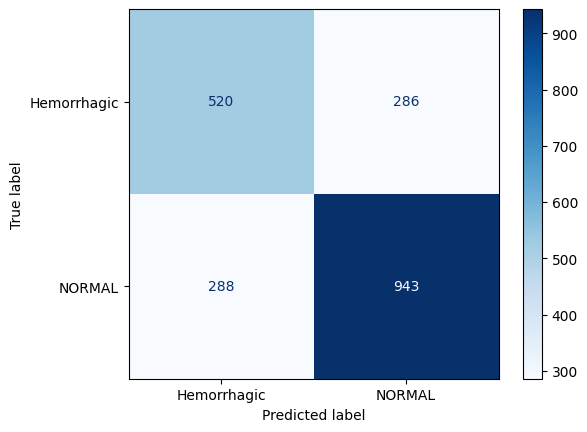

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true = validation_generator.classes  # True labels
y_pred = model.predict(validation_generator, verbose=1)  # Model predictions
y_pred = (y_pred > 0.5).astype(int)  # Threshold predictions for binary classification

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_labels = list(validation_generator.class_indices.keys())

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

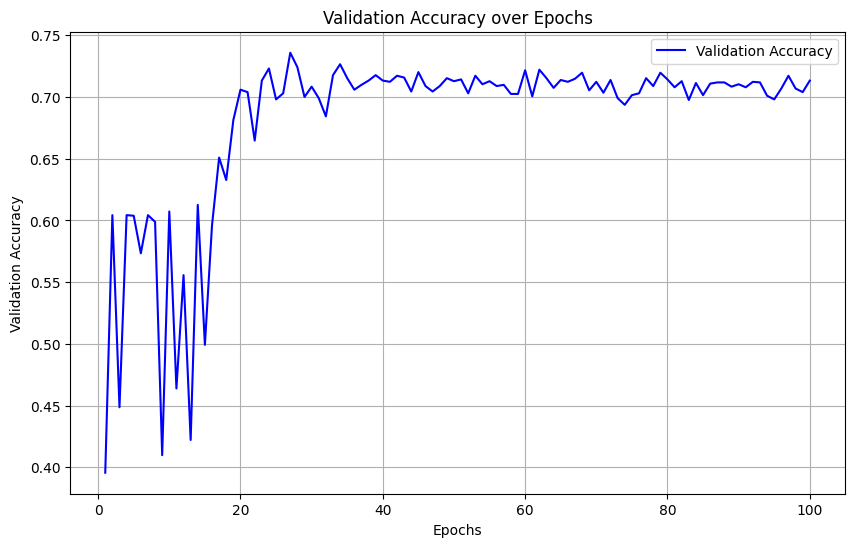

In [12]:
import matplotlib.pyplot as plt

# Get the number of epochs
epochs = range(1, len(history.history['val_accuracy']) + 1)

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()
